In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')


In [3]:
import numpy as np
import os
from make_dataset import make_dataset
from apply_fft import  apply_fft
import matplotlib.pyplot as plt

In [3]:
num_samples = 1200 #样本点数
fs = 12000; # 采样频率

In [4]:
data_path = r'F:\Dateset\CWRU' # 数据集路径

cls_0 = '12K_DE_Normal/*'; 
cls_1 = '12k_DE_IRFault_0.007/*';   cls_2 = '12k_DE_IRFault_0.014/*';   cls_3 = '12k_DE_IRFault_0.021/*'; 
cls_4 = '12k_DE_BallFault_0.007/*'; cls_5 = '12k_DE_BallFault_0.014/*'; cls_6 = '12k_DE_BallFault_0.021/*' #'12k_DE_BallFault_0.021/*', '1772_12k_DE_BallFault_0.021/*'  
cls_7 = '12k_DE_ORFault_0.007/*';    cls_8 = '12k_DE_ORFault_0.014/*';   cls_9 ='12k_DE_ORFault_0.021/*'

norm, y_norm = make_dataset(os.path.join(data_path, cls_0), num_samples, 0)
defc1, y_defc1 = make_dataset(os.path.join(data_path, cls_1), num_samples, 1)
defc2, y_defc2 = make_dataset(os.path.join(data_path, cls_2), num_samples, 2)
defc3, y_defc3 = make_dataset(os.path.join(data_path, cls_3), num_samples, 3)
defc4, y_defc4 = make_dataset(os.path.join(data_path, cls_4), num_samples, 4)
defc5, y_defc5 = make_dataset(os.path.join(data_path, cls_5), num_samples, 5)
defc6, y_defc6 = make_dataset(os.path.join(data_path, cls_6), num_samples, 6)
defc7, y_defc7 = make_dataset(os.path.join(data_path, cls_7), num_samples, 7)
defc8, y_defc8 = make_dataset(os.path.join(data_path, cls_8), num_samples, 8)
defc9, y_defc9 = make_dataset(os.path.join(data_path, cls_9), num_samples, 9)

In [5]:
X = np.concatenate((norm, defc1, defc2, defc3, defc4, defc5, defc6, defc7, defc8, defc9), axis=0, out=None)
Y = np.concatenate((y_norm, y_defc1, y_defc2, y_defc3, y_defc4, y_defc5, 
                    y_defc6, y_defc7, y_defc8, y_defc9), axis=0, out=None)

In [6]:
import pywt

In [7]:
wavelet_function = "db4"
num_levels = 3 # 
m = 1 # 

num_features = 2**num_levels
features = np.repeat(np.nan, len(X)*m*num_features).reshape(len(X),m*num_features)

for i in range(len(X)):    
    wp = pywt.WaveletPacket(X[i], wavelet = wavelet_function, maxlevel = num_levels) # Wavelet packet transformation
    packet_names = [node.path for node in wp.get_level(num_levels, "natural")]
    for j in range(num_features):
        new_wp = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
        new_wp[packet_names[j]] = wp[packet_names[j]].data
        reconstructed_signal = new_wp.reconstruct(update = False) # Signal reconstruction from wavelet packet coefficients
        f, c = apply_fft(reconstructed_signal, fs, len(reconstructed_signal))
        z = abs(c)
        
        maximal_idx = np.argpartition(z, -m)[-m:]
        high_amp = z[maximal_idx]
        high_freq = f[maximal_idx]
        feature = high_amp*high_freq
        
        l = 0
        for f in feature:
            features[i,j*m+l] = f
            l = l+1

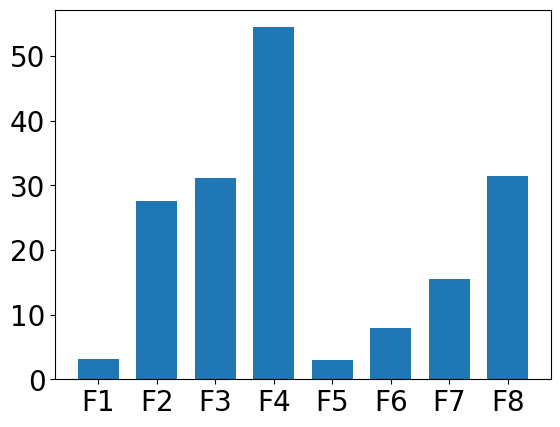

In [8]:
plt.rc('font', size=20)
X_Labels = ['F1','F2','F3','F4','F5','F6','F7','F8']
plt.bar(X_Labels, features[0], 0.7)#,  size=15)
plt.show()

In [4]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns

In [5]:
## 划分测试集和训练集
train_ratio = 0.8 # 训练集比例

data = pd.read_csv('seeds_dataset.txt', header=None, delim_whitespace=True) # delim_whitespace=True表示分割符为空白字符
data.info
Data = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# 划分
X_train, X_test, Y_train, Y_test = train_test_split(Data, labels, train_size=train_ratio, stratify=labels) 

""" labels = pd.Categorical(Y)
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2, 
                                            stratify = labels, random_state = 42) """

# 使用StandardScaler类归一化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
labels = pd.Categorical(Y)
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2, 
                                            stratify = labels, random_state = 42)

# 使用StandardScaler类归一化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
""" from HD import hd
from INNHD import innhd
from NNHD import nnhd """

' from HD import hd\nfrom INNHD import innhd\nfrom NNHD import nnhd '

In [28]:
## 定义超圆盘分类器类
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint  
import pickle
from cvxopt import matrix,solvers 
import cvxpy as cp
import mosek

class hd(BaseEstimator, ClassifierMixin):
    def __init__(self, sigma=0) -> None:
        super().__init__()
        self.sigma = sigma
        self.classes = 0
        self.s_r = {}
        self.beta = {}
        self.classifiers = {}
        self.predictData = None
        self.accuracy = 0

    def gaussian_kernel(self, x1, x2):
        return np.exp(-np.linalg.norm(x1-x2)**2 / (2 * (self.sigma ** 2)))
    
    def jacabian1(self, beta, X):
        """返回超圆盘的对偶问题的目标函数的雅可比矩阵
        Args:
            beta (ndarray): 为该输入样本集合下的拉格朗日系数
            X (ndarray): X为输入样本矩阵, 行为样本个数, 列为样本特征
        """
        return np.sum(X*X, 1)-2*np.sum(X@(X.T*beta), 1)

    def fit(self, X, y):
        # 拟合函数
        classes = np.unique(y)
        Num = np.size(classes)
        beta = {}
        s_and_r = {}
        # 分类求解超圆盘对偶问题拉格朗日系数，以求解s和r
        for i, class_name in enumerate(classes):
            Xx = X[y==class_name, :]
            M = Xx.shape[0]
            P = [[self.gaussian_kernel(Xx[ii], Xx[jj]) for jj in range(M)] for ii in range(M)]
            P = 2*np.array(P)
            q = -np.diag(P)/2
            
            """ P = 2*Xx@Xx.T
            q = -np.diag(Xx@Xx.T) """
            G = np.concatenate((np.eye(M), -np.eye(M)), axis=0)
            h = np.concatenate((np.ones([M, 1]), -np.zeros([M, 1])), axis=0)
            P = matrix(np.array(P), tc='d')
            q = matrix(np.array(q), tc='d')
            G = matrix(np.array(G), tc='d')
            h = matrix(np.array(h), tc='d')
            A = matrix(np.ones([1, M]), tc='d')
            b = matrix(np.array([[1]]), tc='d')
            
            sol = solvers.qp(P, q, G, h, A, b)
            result1 = np.array(sol['x']).flatten()
            beta[class_name] = result1                  
            s = np.sum(result1.reshape(-1, 1)*Xx, 0)
            
            r = np.max(np.linalg.norm(Xx-s, ord=2,axis=1))
            s_and_r[class_name] = np.concatenate([s, [r]])
            
        self.s_r = s_and_r
        self.beta = beta
        print('Over first!')
        # 求解多个分类器的参数，即分类超平面参数，OVO策略
        Num_classifier = int(Num*(Num-1)/2)
        b_classifier = np.zeros((Num_classifier, 1))
        iter = 0
        beta_keys = list(beta.keys())
        sr_keys = list(s_and_r.keys())
        for i in range(Num-1):
            for j in range(i+1, Num):
                iter += 1
                beta_i = beta_keys[i]
                beta_j = beta_keys[j]
                sr_i = sr_keys[i]
                sr_j = sr_keys[j]
                # 获取基本信息
                X_plus = X[y==classes[i], :]
                X_minus = X[y==classes[j], :]
                M_plus = X_plus.shape[0]
                M_minus = X_minus.shape[0]
                beta_plus = np.array(beta[beta_i])
                beta_minus = np.array(beta[beta_j])
                beta = np.concatenate((beta_plus, beta_minus))
                r_plus = np.array(s_and_r[sr_i])[-1]
                r_minus = np.array(s_and_r[sr_j])[-1]
                
                # 目标函数
                XX = np.concatenate((X_plus, X_minus), axis=0, out=None) # [X+;X-]
                MM = XX.shape[0]
                P = [[self.gaussian_kernel(XX[ii], XX[jj]) for jj in range(MM)] for ii in range(MM)]
                P = np.array(P)
                P[0:M_plus, M_plus:] = - P[:M_plus, M_plus:]
                P[M_plus:, :M_plus] = - P[M_plus:, : M_plus]
                # 约束
                A = np.zeros([2, XX.shape[0]])
                A[0,: M_plus] = 1
                A[1, M_plus:] = 1
                b = np.array([1, 1])
                # 二次约束, first
                transfer_plus = np.zeros([MM, M_plus])
                transfer_plus[:M_plus, :M_plus] = np.ones([M_plus, M_plus]) # 将[α+， α-]转化为[α+]
                Q_plus = np.array([[self.gaussian_kernel(X_plus[ii], X_plus[jj]) for jj in range(M_plus)] for ii in range(M_plus)])
                P1 = transfer_plus@Q_plus@transfer_plus.T
                q1 = - beta_plus@Q_plus@transfer_plus.T
                h1 = r_plus**2 - np.dot(beta_plus, Q_plus@beta_plus)
                # 二次约束, second
                transfer_minus = np.zeros([MM, M_minus])
                transfer_minus[M_plus:, :M_plus] = np.ones([M_minus, M_minus]) # 将[α+， α-]转化为[α+]
                Q_minus = np.array([[self.gaussian_kernel(X_minus[ii], X_minus[jj]) for jj in range(M_minus)] for ii in range(M_minus)])
                P2 = transfer_minus@Q_minus@transfer_minus.T
                q2 = - beta_minus@Q_minus@transfer_minus.T
                h2 = r_minus**2 - np.dot(beta_minus, Q_minus@beta_minus)
                
                alpha = cp.Variable(MM)
                prob = cp.Problem(cp.Minimize(cp.quad_form(alpha, P)),
                                [
                                 A @ alpha == b]) #cp.quad_form(alpha, P1) + q1 @ alpha <= h1, cp.quad_form(alpha, P2) + q2 @ alpha <= h2,
                #prob.solve(solver=cp.MOSEK)
                prob.solve()
                ALPHA = alpha.value
                print(ALPHA)
                alpha_plus = ALPHA[:M_plus]
                alpha_minus = ALPHA[M_plus:]
                # 求解b
                for k in range(M_plus):
                    b_classifier[iter-1] += np.sum(alpha_plus[k]*alpha_plus*self.gaussian_kernel(X_plus[k, :], X_plus))
                for k in range(M_minus):
                    b_classifier[iter-1] -= np.sum(alpha_minus[k]*alpha_minus*self.gaussian_kernel(X_minus[k, :], X_minus))
                b_classifier[iter-1] = -1/2*b_classifier[iter-1]
                b = b_classifier[iter-1]
                self.classes = Num
                self.classifiers[(classes[i], classes[j])] = {'X+': X_plus,
                                                'X-': X_minus,
                                                'alpha+': alpha_plus,
                                                'alpha-': alpha_minus,
                                                'b': b}     
                
    def predict(self,X):
        fx = np.zeros((X.shape[0], self.classes))
        indexclasses = 0
        fxij = np.zeros((X.shape[0], self.classes))
        for (i, j), classifier in self.classifiers.items():
            indexclasses += 1
            X_pl = classifier['X+']
            X_mi = classifier['X-']
            alpha_pl = classifier['alpha+']
            alpha_mi = classifier['alpha-']
            bb = classifier['b']
            
            M_plus = X_pl.shape[0]
            M_minus = X_mi.shape[0]
            
            for g in range(M_plus):
                fx[:, indexclasses-1] = fx[:, indexclasses-1] + alpha_pl[g]*self.gaussian_kernel(X_pl[g, :], X).reshape(-1)
            for g in range(M_minus):
                fx[:, indexclasses-1] = fx[:, indexclasses-1] - alpha_mi[g]*self.gaussian_kernel(X_mi[g, :], X).reshape(-1)
            
            fx[:, indexclasses-1] = np.sign(fx[:, indexclasses-1] + bb)
            fxij[:, indexclasses-1] = fx[:, indexclasses-1] 
            fx[:, indexclasses-1][fx[:, indexclasses-1]==1] = i
            fx[:, indexclasses-1][fx[:, indexclasses-1]==-1] = j
            fx[:, indexclasses-1][fx[:, indexclasses-1]==0] = 0


        y_pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(x.astype(int))), axis=1, arr=fx) # axis表示假如你是n×m维度，axis=0，表示在n方向上，axis=1，表示在m方向上
        y_pred = y_pred.reshape(-1, 1)
        self.predictData = np.concatenate((X, y_pred, fxij, fx), axis=1)
        return y_pred
    
    def score(self, y_pred, y):
        y = y.reshape(-1, 1)
        accuray = np.sum(y_pred==y) / y.shape[0]
        self.accuracy = accuray
        return accuray

In [13]:
# 网格搜索最佳sigma
param_grid = {'sigma': (2 ** np.arange(-5, 5.5, 0.5)).tolist()}

testmodel = hd()
grid_search = GridSearchCV(testmodel, param_grid=param_grid, scoring='accuracy', cv=5, verbose=5)
grid_search.fit(X_train_scaled, Y_train)
sigma = grid_search.best_params_
score = grid_search.best_score_
print(sigma, score)
sigma = sigma['sigma']
with open('sigma.pkl', 'wb') as f:
    pickle.dump(sigma, f)


Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END .....................sigma=0.03125;, score=1.000 total time=   0.9s
[CV 2/5] END .....................sigma=0.03125;, score=1.000 total time=   0.8s
[CV 3/5] END .....................sigma=0.03125;, score=1.000 total time=   0.8s
[CV 4/5] END .....................sigma=0.03125;, score=1.000 total time=   0.8s
[CV 5/5] END .....................sigma=0.03125;, score=1.000 total time=   0.8s
[CV 1/5] END .........sigma=0.04419417382415922;, score=1.000 total time=   0.8s
[CV 2/5] END .........sigma=0.04419417382415922;, score=1.000 total time=   0.8s
[CV 3/5] END .........sigma=0.04419417382415922;, score=1.000 total time=   0.8s
[CV 4/5] END .........sigma=0.04419417382415922;, score=1.000 total time=   0.8s
[CV 5/5] END .........sigma=0.04419417382415922;, score=1.000 total time=   0.8s
[CV 1/5] END ......................sigma=0.0625;, score=1.000 total time=   0.8s
[CV 2/5] END ......................sigma=0.0625

In [7]:
with open('sigma.pkl', 'rb') as f:
    sigma = pickle.load(f)


In [29]:
## 训练
model = hd(sigma) # 必须有输入值！！
model.fit(X_train_scaled, Y_train)

     pcost       dcost       gap    pres   dres
 0: -9.8214e-01 -5.7946e+01  6e+01  4e-15  0e+00
 1: -9.8214e-01 -1.5518e+00  6e-01  1e-15  2e-16
 2: -9.8214e-01 -9.8784e-01  6e-03  2e-15  2e-17
 3: -9.8214e-01 -9.8220e-01  6e-05  1e-15  1e-16
 4: -9.8214e-01 -9.8214e-01  6e-07  2e-15  4e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.8214e-01 -5.7946e+01  6e+01  7e-16  1e-16
 1: -9.8214e-01 -1.5518e+00  6e-01  3e-15  3e-16
 2: -9.8214e-01 -9.8784e-01  6e-03  8e-16  3e-17
 3: -9.8214e-01 -9.8220e-01  6e-05  1e-15  7e-18
 4: -9.8214e-01 -9.8214e-01  6e-07  2e-15  4e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.8214e-01 -5.7946e+01  6e+01  3e-15  2e-17
 1: -9.8214e-01 -1.5518e+00  6e-01  6e-16  2e-16
 2: -9.8214e-01 -9.8784e-01  6e-03  1e-16  2e-17
 3: -9.8214e-01 -9.8220e-01  6e-05  2e-16  2e-17
 4: -9.8214e-01 -9.8214e-01  6e-07  3e-16  7e-17
Optimal solution found.
Over first!
[0.01785714 0.01785714 0.01785714 0.0

ValueError: zero-dimensional arrays cannot be concatenated

In [16]:
# 测试
Y_pred = model.predict(X_test_scaled)

F1 Score = 1.0
Accuracy = 100.000 %


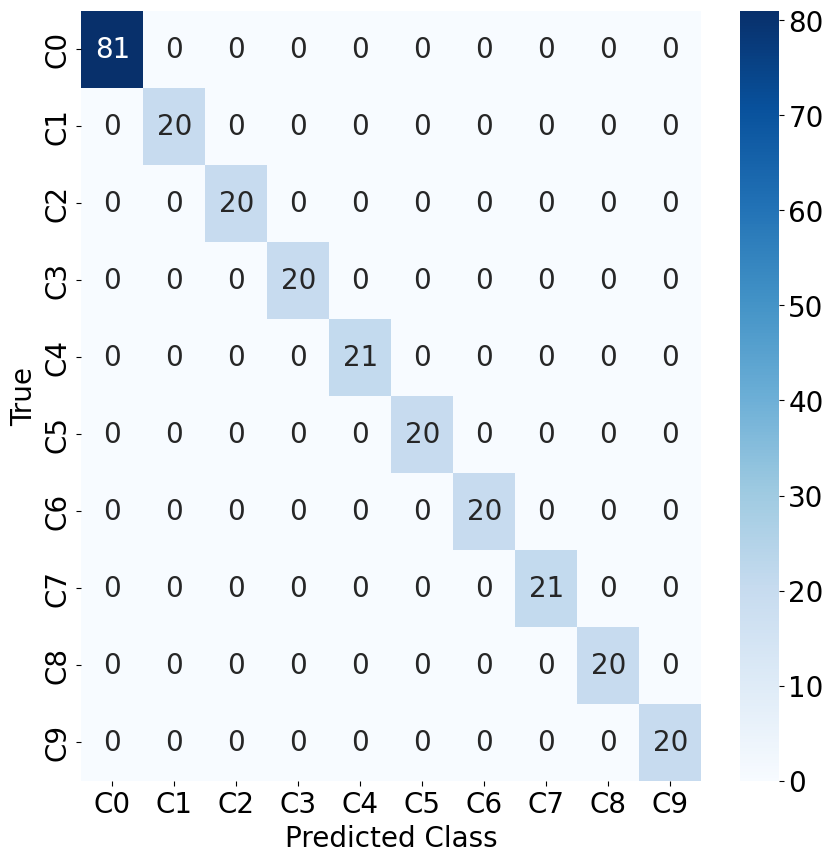

In [17]:
Accuracy = accuracy_score(Y_test, Y_pred)
test_confu_matrix = confusion_matrix(Y_test, Y_pred)
fault_type = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
plt.figure(figsize=(10, 10))
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.ylabel('True')
F1_score = f1_score(Y_test, Y_pred,average='micro')

print("F1 Score =", F1_score)
print("Accuracy = %.3f" % (Accuracy*100), "%")


In [18]:
BETA = model.beta
print(np.max(BETA, 1))
print(np.sum(BETA,1))

[0.01234574 0.0123459  0.01234568 0.0125103  0.01234748 0.01236461
 0.0125     0.01234576 0.01234568 0.00953381]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [19]:
# 多工况测试
# 创建其余工况数据
ceshi_1 = '1730_12k_DE_IRFault_0.007/*'; ceshi_4 = '1730_12k_DE_IRFault_0.014/*'; ceshi_7 = '1730_12k_DE_IRFault_0.021/*';
ceshi_2 = '1772_12k_DE_IRFault_0.007/*'; ceshi_5 = '1772_12k_DE_IRFault_0.014/*'; ceshi_8 = '1772_12k_DE_IRFault_0.021/*';
ceshi_3 = '1797_12k_DE_IRFault_0.007/*'; ceshi_6 = '1797_12k_DE_IRFault_0.014/*'; ceshi_9 = '1797_12k_DE_IRFault_0.021/*';

ceshi_10 = '1730_12k_DE_BallFault_0.007/*'; ceshi_13 = '1730_12k_DE_BallFault_0.014/*'; ceshi_16 = '1730_12k_DE_BallFault_0.021/*'; # '1730_12k_DE_BallFault_0.021/*'   
ceshi_11 = '1772_12k_DE_BallFault_0.007/*'; ceshi_14 = '1772_12k_DE_BallFault_0.014/*'; ceshi_17 = '1772_12k_DE_BallFault_0.021/*'; # '1772_12k_DE_BallFault_0.021/*';  
ceshi_12 = '1797_12k_DE_BallFault_0.007/*'; ceshi_15 = '1797_12k_DE_BallFault_0.014/*'; ceshi_18 = '12k_DE_BallFault_0.021/*'; # '1797_12k_DE_BallFault_0.021/*'

ceshi_19 = '1730_12k_DE_ORFault_0.007/*'; ceshi_22 = '1730_12k_DE_ORFault_0.014/*'; ceshi_25 = '1730_12k_DE_ORFault_0.021/*';
ceshi_20 = '1772_12k_DE_ORFault_0.007/*'; ceshi_23 = '1772_12k_DE_ORFault_0.014/*'; ceshi_26 = '1772_12k_DE_ORFault_0.021/*';
ceshi_21 = '1797_12k_DE_ORFault_0.007/*'; ceshi_24 = '1797_12k_DE_ORFault_0.014/*'; ceshi_27 = '1797_12k_DE_ORFault_0.021/*';
       

ceshi_defc1, ceshi_y_defc1 = make_dataset(os.path.join(data_path, ceshi_1), num_samples, 1)
ceshi_defc2, ceshi_y_defc2 = make_dataset(os.path.join(data_path, ceshi_2), num_samples, 1)
ceshi_defc3, ceshi_y_defc3 = make_dataset(os.path.join(data_path, ceshi_3), num_samples, 1) 
ceshi_defc4, ceshi_y_defc4 = make_dataset(os.path.join(data_path, ceshi_4), num_samples, 2)
ceshi_defc5, ceshi_y_defc5 = make_dataset(os.path.join(data_path, ceshi_5), num_samples, 2)
ceshi_defc6, ceshi_y_defc6 = make_dataset(os.path.join(data_path, ceshi_6), num_samples, 2)
ceshi_defc7, ceshi_y_defc7 = make_dataset(os.path.join(data_path, ceshi_7), num_samples, 3)
ceshi_defc8, ceshi_y_defc8 = make_dataset(os.path.join(data_path, ceshi_8), num_samples, 3)
ceshi_defc9, ceshi_y_defc9 = make_dataset(os.path.join(data_path, ceshi_9), num_samples, 3) 
ceshi_defc10, ceshi_y_defc10 = make_dataset(os.path.join(data_path, ceshi_10), num_samples, 4)
ceshi_defc11, ceshi_y_defc11 = make_dataset(os.path.join(data_path, ceshi_11), num_samples, 4)
ceshi_defc12, ceshi_y_defc12 = make_dataset(os.path.join(data_path, ceshi_12), num_samples, 4) 
ceshi_defc13, ceshi_y_defc13 = make_dataset(os.path.join(data_path, ceshi_13), num_samples, 5)
ceshi_defc14, ceshi_y_defc14 = make_dataset(os.path.join(data_path, ceshi_14), num_samples, 5)
ceshi_defc15, ceshi_y_defc15 = make_dataset(os.path.join(data_path, ceshi_15), num_samples, 5) 
ceshi_defc16, ceshi_y_defc16 = make_dataset(os.path.join(data_path, ceshi_16), num_samples, 6)
ceshi_defc17, ceshi_y_defc17 = make_dataset(os.path.join(data_path, ceshi_17), num_samples, 6)
ceshi_defc18, ceshi_y_defc18 = make_dataset(os.path.join(data_path, ceshi_18), num_samples, 6) 
ceshi_defc19, ceshi_y_defc19 = make_dataset(os.path.join(data_path, ceshi_19), num_samples, 7)
ceshi_defc20, ceshi_y_defc20 = make_dataset(os.path.join(data_path, ceshi_20), num_samples, 7) 
ceshi_defc21, ceshi_y_defc21 = make_dataset(os.path.join(data_path, ceshi_21), num_samples, 7) 
ceshi_defc22, ceshi_y_defc22 = make_dataset(os.path.join(data_path, ceshi_22), num_samples, 8)
ceshi_defc23, ceshi_y_defc23 = make_dataset(os.path.join(data_path, ceshi_23), num_samples, 8) 
ceshi_defc24, ceshi_y_defc24 = make_dataset(os.path.join(data_path, ceshi_24), num_samples, 8) 
ceshi_defc25, ceshi_y_defc25 = make_dataset(os.path.join(data_path, ceshi_25), num_samples, 9)
ceshi_defc26, ceshi_y_defc26 = make_dataset(os.path.join(data_path, ceshi_26), num_samples, 9) 
ceshi_defc27, ceshi_y_defc27 = make_dataset(os.path.join(data_path, ceshi_27), num_samples, 9)

ceshi_X = np.concatenate((ceshi_defc1, ceshi_defc2, ceshi_defc3, ceshi_defc4, ceshi_defc5, ceshi_defc6, ceshi_defc7, ceshi_defc8, ceshi_defc9, 
                          ceshi_defc10, ceshi_defc11, ceshi_defc12, ceshi_defc13, ceshi_defc14, ceshi_defc15, ceshi_defc16, ceshi_defc17, ceshi_defc18,
                          ceshi_defc19, ceshi_defc20, ceshi_defc21, ceshi_defc22, ceshi_defc23, ceshi_defc24, ceshi_defc25, ceshi_defc26, ceshi_defc27), axis=0, out=None)
ceshi_Y = np.concatenate((ceshi_y_defc1, ceshi_y_defc2, ceshi_y_defc3, ceshi_y_defc4, ceshi_y_defc5, ceshi_y_defc6, ceshi_y_defc7, ceshi_y_defc8, ceshi_y_defc9,
                          ceshi_y_defc10, ceshi_y_defc11, ceshi_y_defc12, ceshi_y_defc13, ceshi_y_defc14, ceshi_y_defc15, ceshi_y_defc16, ceshi_y_defc17, ceshi_y_defc18,
                          ceshi_y_defc19, ceshi_y_defc20, ceshi_y_defc21, ceshi_y_defc22, ceshi_y_defc23, ceshi_y_defc24, ceshi_y_defc25, ceshi_y_defc26, ceshi_y_defc27), axis=0, out=None)


In [20]:
wavelet_function = "db4"
num_levels = 3 # 
m = 1 # 

num_features = 2**num_levels
ceshi_features = np.repeat(np.nan, len(ceshi_X)*m*num_features).reshape(len(ceshi_X),m*num_features)

for i in range(len(ceshi_X)):    
    wp = pywt.WaveletPacket(ceshi_X[i], wavelet = wavelet_function, maxlevel = num_levels) # Wavelet packet transformation
    packet_names = [node.path for node in wp.get_level(num_levels, "natural")]
    for j in range(num_features):
        new_wp = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
        new_wp[packet_names[j]] = wp[packet_names[j]].data
        reconstructed_signal = new_wp.reconstruct(update = False) # Signal reconstruction from wavelet packet coefficients
        f, c = apply_fft(reconstructed_signal, fs, len(reconstructed_signal))
        z = abs(c)
        
        maximal_idx = np.argpartition(z, -m)[-m:]
        high_amp = z[maximal_idx]
        high_freq = f[maximal_idx]
        feature = high_amp*high_freq
        
        l = 0
        for f in feature:
            ceshi_features[i,j*m+l] = f
            l = l+1
            
ceshi_labels = pd.Categorical(ceshi_Y)

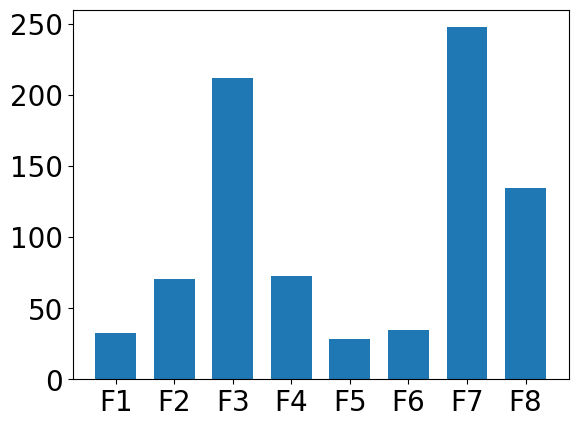

In [21]:
plt.rc('font', size=20)
X_Labels = ['F1','F2','F3','F4','F5','F6','F7','F8']
plt.bar(X_Labels, ceshi_features[0], 0.7)#,  size=15)
plt.show()

In [22]:
ceshi_X_scaled = scaler.transform(ceshi_features)

In [23]:
Multi_envpred = nnhd()

with open('s_r.pkl', 'rb') as f:
    Multi_envpred.s_r = pickle.load(f)
    # print(Multi_envpred.s_r)

ceshi_Y_pred = Multi_envpred.predict(ceshi_X_scaled)

F1 Score = 0.7518301610541727
ceshi_Accuracy = 75.183 %


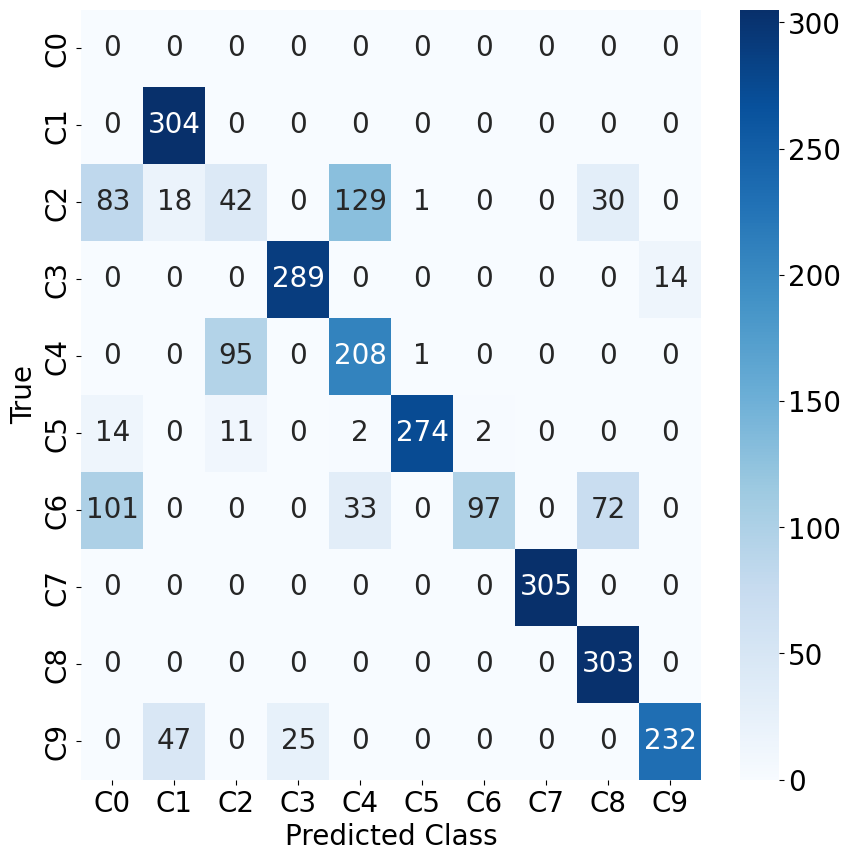

In [26]:
ceshi_Accuracy = accuracy_score(ceshi_Y, ceshi_Y_pred)
ceshi_confu_matrix = confusion_matrix(ceshi_Y, ceshi_Y_pred)
fault_type = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
plt.figure(figsize=(10, 10))
sns.heatmap(ceshi_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.ylabel('True')
F1_score = f1_score(ceshi_Y, ceshi_Y_pred,average='micro')

print("F1 Score =", F1_score)
print("ceshi_Accuracy = %.3f" % (ceshi_Accuracy*100), "%")

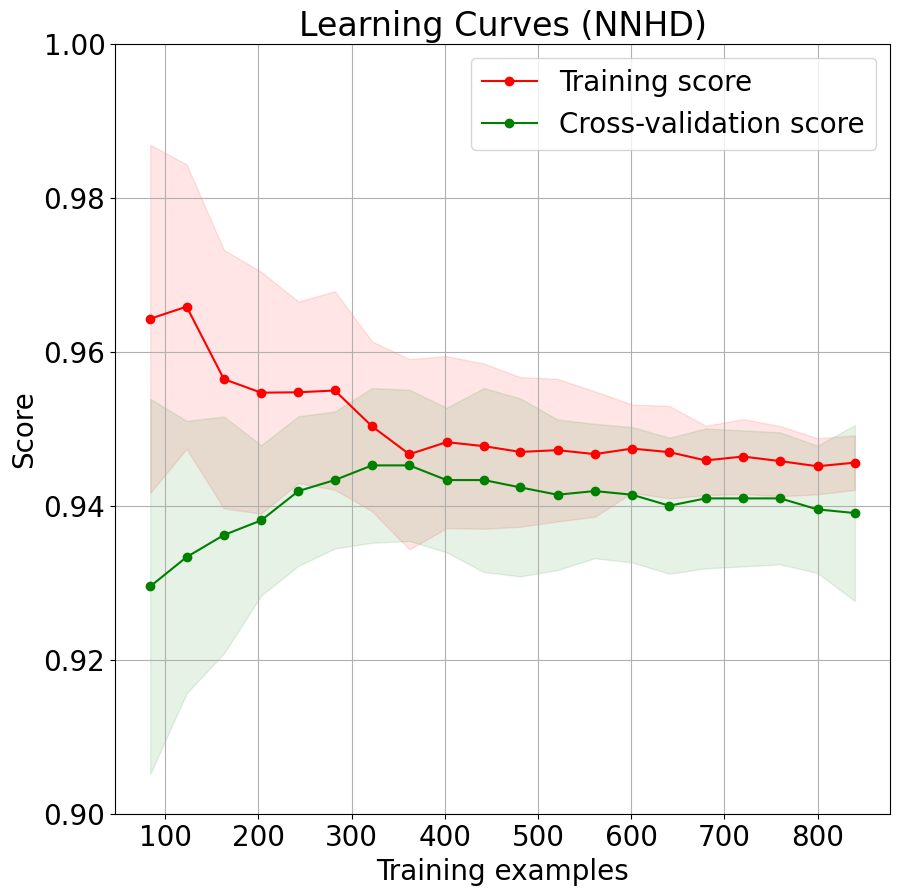

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.datasets import load_digits

title = r"Learning Curves (NNHD)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
estimator = nnhd(sigma)
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train, Y_train, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

plt.figure(figsize=(10, 10))
plt.title(title)
ylim=(0.90, 1.00)
if ylim is not None:
    plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")


plt.show()



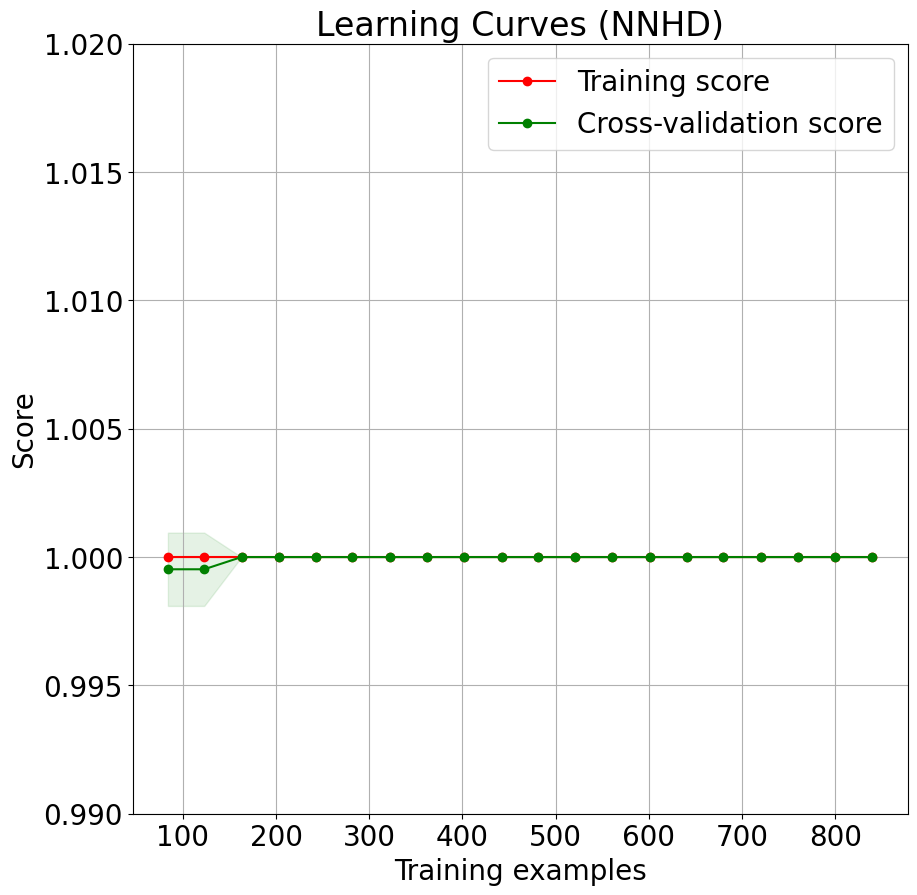

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.datasets import load_digits

title = r"Learning Curves (NNHD)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
estimator = nnhd(sigma)
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train_scaled, Y_train, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

plt.figure(figsize=(10, 10))
plt.title(title)
ylim=(0.99, 1.02)
if ylim is not None:
    plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")


plt.show()

